# Code for interacting with API of openFDA

## Plan
In this project, we are looking for device adverse events. We are particularly interested in:
    - Cause of failure
    - Date of failure (ie age of device)
We want to see which is the most common cause for given device to fail and at which stage of use this occurs.
Relevant fields could be (for full reference see https://open.fda.gov/device/event/reference/):
### Event
device_date_of_manufacturer
date_of_event, date_report, date_received
previous_use_code, remedial_action
single_use_flag
### Source
reprocessed_and_reused_flag
### Device
device.generic_name
device.expiration_date_of_device, device.device_age_text
device.implant_flag, device.date_removed_flag
device.manufacturer_d_name, device.manufacturer_d_state, device.manufacturer_d_country
### Patient
patient.sequence_number_outcome, patient.sequence_number_treatment
### Report Text
mdr_text.text, mdr_text.text_type_code
### Reporter Dependent Fields
#### By user facility / importer
report_date
event_location
manufacturer_name, manufacturer_country
manufacturer_g1_name, manufacturer_g1_state
### OpenFDA fields
device_class
### Further interesting fields:
Source: reporter_occupation_code
Device: device.device_operator

In [1]:
# Import modules
import numpy as np
import pandas as pd
import json
import requests
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans, MiniBatchKMeans
import logging
import sys
from time import time
from datetime import datetime, timedelta

In [2]:
# Build base query
baseurl = 'https://api.fda.gov/device/event.json?'
time_period = 7
initia_date = "20150101"
final_date = datetime.strptime("20150401", "%Y%m%d")
skip = 0
limit = 100

apikey = ''
with open('apikey.txt', 'r') as myfile:
    apikey = myfile.read().replace('\n', '')

### features to check for existence

In [3]:
list_features = ['device_date_of_manufacturer', 
                 'date_of_event',
                 #'date_report',
                 #'date_received',
                 'previous_use_code',
                 #'remedial_action',
                 'single_use_flag',
                 'reprocessed_and_reused_flag',
                 #'reporter_occupation_code',
                 #'device.date_received',
                 #'device.generic_name' # this allows for empty string! 
                ]

# possibility to further narrow donw the search
# list_features_specific = ['device.openfda.device_name:"sensor"', 
#                   #'device.implant_flag:"Y"',
#                   #'previous_use_code:"I"', # I - initial use, R - reuse, U - unknown, * - invalid data
#                   #'device.manufacturer_d_country:"US"' # SZ - Switzerland
#                  ]

#### list of usable device names 

In [4]:
list_device_names = ["pump",
                    "sensor",
                    "prosthesis",
                    "defibrilator",
                    "pacemaker",
                    "catheter",
                    "electrode",
                    #"wearable",
                     "stent",
                     "ray",
                     "ventilator",
                     "bed",
                     "implant",
                     "lens",
                     #"mds" # https://www.cancer.org/cancer/myelodysplastic-syndrome/about/what-is-mds.html
                     "dialysis",
                     "graft",
                    ]
                  

## Build full query

In [5]:
start_date = datetime.strptime(initia_date, "%Y%m%d")
end_date = start_date +  timedelta(days=time_period)
device_name = list_device_names[4]
results = []

while True:
    skip = 0
    
    while (skip<=5000):
        query = 'search=device.generic_name:'+device_name+'+AND+'
        # adding date range
        start = str(start_date.date()).replace("_", "")
        end = str(end_date.date()).replace("_", "")
        query = query+"date_of_event:[\""+start+"\""+"+TO+"+"\""+end+"\"]"
        
        # checking features for existence
        for x in list_features:
            query = query + "+AND+_exists_:" + x
            
        # # Possibility to furhter narrow down the search
        # for y in list_features_specific:
        #     query = query + "+AND+" + y

        
        q1 = baseurl + 'api_key=' + apikey + '&' + query + '&' + 'limit=' + str(limit) + '&' + 'skip=' + str(skip)
        dq1 = requests.get(q1)
        # dq1.json()['results']
        data = json.loads(dq1.text)

        if "results" in data:
            result = data['results']
            results = results + result
            print(len(results))
            skip = skip + limit
        else:
            break

    print("Week Done")
    start_date = end_date + timedelta(days=1)
    end_date = start_date +  timedelta(days=time_period)
    if start_date > final_date:
        break
        
    if end_date > final_date:
        end_date = final_date

'''
# adding date range
query = query+"date_of_event:[\""+start_date+"\""+"+TO+"+"\""+end_date+"\"]"

# checking features for existence
for x in list_features:
    query = query + "+AND+_exists_:" + x

# # Possibility to furhter narrow down the search
# for y in list_features_specific:
#     query = query + "+AND+" + y

# Search for specific device, see the list abvoe
name_query = '+AND+device.openfda.device_name:' + device_name ;

# Construct final query
# q1 = baseurl + 'api_key=' + apikey + '&' + query + '&' + 'limit=' + str(limit)
q2 = baseurl + 'api_key=' + apikey + '&' + query + name_query + '&' +'limit=' + str(limit)
'''

100
200
300
400
448
Week Done
548
648
748
848
948
1023
Week Done
1123
1223
1323
1423
1434
Week Done
1534
1634
1734
1834
1878
Week Done
1978
2078
2178
2278
2378
Week Done
2478
2578
2678
2778
2851
Week Done
2951
3051
3151
3251
3343
Week Done
3443
3543
3643
3743
3843
3875
Week Done
3975
4075
4175
4275
4355
Week Done
4455
4555
4655
4755
4831
Week Done
4931
5031
5131
5231
5312
Week Done
5412
5512
5612
5617
Week Done


'\n# adding date range\nquery = query+"date_of_event:[""+start_date+"""+"+TO+"+"""+end_date+""]"\n\n# checking features for existence\nfor x in list_features:\n    query = query + "+AND+_exists_:" + x\n\n# # Possibility to furhter narrow down the search\n# for y in list_features_specific:\n#     query = query + "+AND+" + y\n\n# Search for specific device, see the list abvoe\nname_query = \'+AND+device.openfda.device_name:\' + device_name ;\n\n# Construct final query\n# q1 = baseurl + \'api_key=\' + apikey + \'&\' + query + \'&\' + \'limit=\' + str(limit)\nq2 = baseurl + \'api_key=\' + apikey + \'&\' + query + name_query + \'&\' +\'limit=\' + str(limit)\n'

In [58]:
''' # Checking the number of data points for each device
dq = requests.get(q2)
# dq1.json()['results']
data = json.loads(dq.text)
number = data['meta']['results']['total'] # check number of matching entries
results = data['results']
number
'''

" # Checking the number of data points for each device\ndq = requests.get(q2)\n# dq1.json()['results']\ndata = json.loads(dq.text)\nnumber = data['meta']['results']['total'] # check number of matching entries\nresults = data['results']\nnumber\n"

In [6]:
# Can also spare some structuring effort when loading data by calling normalization method
# dftest = pd.io.json.json_normalize(results)
len(results)

5617

In [7]:
# check that you obtained what you expected
results[3]

{'adverse_event_flag': 'Y',
 'date_manufacturer_received': '20150224',
 'date_of_event': '20150107',
 'date_received': '20150126',
 'date_report': '20150224',
 'device': [{'brand_name': 'CAPSUREEPI',
   'catalog_number': '4968-25',
   'date_received': '20150126',
   'date_removed_flag': '',
   'date_returned_to_manufacturer': '20150112',
   'device_age_text': 'DA',
   'device_availability': 'Device was returned to manufacturer',
   'device_evaluated_by_manufacturer': 'Y',
   'device_event_key': '',
   'device_operator': 'LAY USER/PATIENT',
   'device_report_product_code': 'DTB',
   'device_sequence_number': ' 1.0',
   'expiration_date_of_device': '20121128',
   'generic_name': 'ELECTRODE, PACEMAKER, PERMANENT',
   'implant_flag': '',
   'lot_number': '',
   'manufacturer_d_address_1': '8200 CORAL SEA STREET NE',
   'manufacturer_d_address_2': '',
   'manufacturer_d_city': 'MOUNDS VIEW',
   'manufacturer_d_country': 'US',
   'manufacturer_d_name': 'MEDTRONIC, INC.',
   'manufacturer_d_p

In [8]:
# Fields of Interest
fois_result = ['device_date_of_manufacturer',
               'date_of_event']
fois_device = [#'generic_name', 
               'expiration_date_of_device', 
               #'device_age_text', 
               'implant_flag', 
               #'date_removed_flag', \
               'manufacturer_d_name', 
               #'manufacturer_d_state',
               'manufacturer_d_country'
              ]
fois_patient = [#'sequence_number_outcome',
                #'sequence_number_treatment'
              ]
fois_mdrText = ['text',
                'text_type_code']
fois_openfda = ['device_name',
                'device_class',
                'medical_specialty_description']

# device = data['results'][0]['device'][0]
device = [x['device'][0] for x in results]
# patient = data['results'][0]['patient'][0]
patient = [x['patient'][0] for x in results]
# mdrText = data['results'][0]['mdr_text'][0] # there may be more items in the list! 
mdrText = [x['mdr_text'] for x in results]
#mdrText = [y['text'] for y in [x['mdr_text'][0] for x in data['results']]]
# openfda = data['results'][0]['device'][0]['openfda']
openfda = [x['device'][0]['openfda'] for x in results]

In [9]:
# Create sub dataframes for non-multiple columns
df_results = pd.DataFrame(results, index = range(len(results)), columns = fois_result)
df_openfda = pd.DataFrame(openfda, index = range(len(results)),columns = fois_openfda)
df_device = pd.DataFrame(device, index = range(len(results)),columns = fois_device)
df_patient = pd.DataFrame(patient, index = range(len(results)),columns = fois_patient)
# df_mdrText = pd.DataFrame(mdrText, index = range(len(results)),columns = fois_mdrText)

# df = pd.concat([df_device, df_patient, df_mdrText, df_openfda], axis = 1)

In [10]:
# Pull out all relevant text fields
fillDic = {'mdr_text_key': '', 'patient_sequence_number': '', 'text': np.nan, 'text_type_code': np.nan}
a = [x[0] if len(x) > 0 else fillDic for x in mdrText]
b = [x[1] if len(x) > 1 else fillDic for x in mdrText]
c = [x[2] if len(x) > 2 else fillDic for x in mdrText] 


a = pd.DataFrame(a, index = range(len(results)),columns = fois_mdrText)
b = pd.DataFrame(b, index = range(len(results)),columns = fois_mdrText)
c = pd.DataFrame(c, index = range(len(results)),columns = fois_mdrText)

In [11]:
# Rename duplicate columns:
fois_mdrText_a = [x + '_0' for x in fois_mdrText]
fois_mdrText_b = [x + '_1' for x in fois_mdrText]
fois_mdrText_c = [x + '_2' for x in fois_mdrText]

columns_a = dict(zip(fois_mdrText, fois_mdrText_a))
columns_b = dict(zip(fois_mdrText, fois_mdrText_b))
columns_c = dict(zip(fois_mdrText, fois_mdrText_c))

a.rename(columns = columns_a, inplace = True)
b.rename(columns = columns_b, inplace = True)
c.rename(columns = columns_c, inplace = True)

# I haven't seen a four-field entry. If there were some, we would need to deal with them in smarter way

In [12]:
# Construct final data frame
df_mdrText = pd.concat([a, b, c], axis = 1)

# Concatenate into final dataframe
df = pd.concat([df_results, df_device, df_patient, df_mdrText, df_openfda], axis = 1)

In [13]:
# Determine age of device in days
df['age_of_device_days'] = pd.to_datetime(df['date_of_event'], format='%Y%m%d') \
- pd.to_datetime(df['device_date_of_manufacturer'], format='%Y%m%d')


# Determine timedelta from failure to specified expiry date
df['days_to_expiry'] = pd.to_datetime(df['expiration_date_of_device'], format='%Y%m%d') \
- pd.to_datetime(df['device_date_of_manufacturer'], format='%Y%m%d')
df = df.drop(['date_of_event','device_date_of_manufacturer', 'expiration_date_of_device'], axis = 1)

In [14]:
df

,implant_flag,manufacturer_d_name,manufacturer_d_country,text_0,text_type_code_0,text_1,text_type_code_1,text_2,text_type_code_2,device_name,device_class,medical_specialty_description,age_of_device_days,days_to_expiry
0,,ST JUDE MEDICAL CARDIAC RHYTHM MANAGEMENT DIVI...,US,"ALL INFORMATION PROVIDED BY MANUFACTURER, NO M...",Additional Manufacturer Narrative,IT WAS REPORTED THAT THE PATIENT'S BLOOD PRESS...,Description of Event or Problem,NaN,NaN,Drug Eluting Permanent Right Ventricular (Rv) ...,3,Unknown,1503 days,1102 days
1,,MPRI,US,THIS EVENT OCCURRED OUTSIDE THE US WHERE THE S...,Additional Manufacturer Narrative,IT WAS REPORTED THAT THE LEAD HAD FAILED PACIN...,Description of Event or Problem,NaN,NaN,Permanent Pacemaker Electrode,3,Cardiovascular,1296 days,1461 days
2,,"ST. JUDE MEDICAL, INC., CRMD",US,IT WAS REPORTED THAT THE PATIENT HAS DECEASED....,Description of Event or Problem,"ALL INFORMATION PROVIDED BY MANUFACTURER, NO M...",Additional Manufacturer Narrative,NaN,NaN,Drug Eluting Permanent Right Ventricular (Rv) ...,3,Unknown,2096 days,1118 days
3,,"MEDTRONIC, INC.",US,PRODUCT EVENT SUMMARY :THE PROXIMAL SEGMENT OF...,Additional Manufacturer Narrative,THE INFORMATION SUBMITTED REFLECTS ALL RELEVAN...,Additional Manufacturer Narrative,IT WAS REPORTED THAT DURING AN UPGRADE PROCEDU...,Description of Event or Problem,Permanent Pacemaker Electrode,3,Cardiovascular,1384 days,614 days
4,,"MEDTRONIC, INC.",US,THE INFORMATION SUBMITTED REFLECTS ALL RELEVAN...,Additional Manufacturer Narrative,IT WAS REPORTED THAT A SLIGHT VARIABILITY WAS ...,Description of Event or Problem,NaN,NaN,Permanent Pacemaker Electrode,3,Cardiovascular,1690 days,680 days
5,,MPRI,US,THE INFORMATION SUBMITTED REFLECTS ALL RELEVAN...,Additional Manufacturer Narrative,IT WAS REPORTED A REMOTE MONITOR TRANSMISSION ...,Description of Event or Problem,NaN,NaN,Permanent Pacemaker Electrode,3,Cardiovascular,560 days,707 days
6,,"MEDTRONIC, INC.",US,IT WAS REPORTED THAT THE RIGHT VENTRICULAR (RV...,Description of Event or Problem,THE INFORMATION SUBMITTED REFLECTS ALL RELEVAN...,Additional Manufacturer Narrative,NaN,NaN,Drug Eluting Permanent Right Ventricular (Rv) ...,3,Unknown,2738 days,612 days
7,,"MEDTRONIC, INC.",US,THE INFORMATION SUBMITTED REFLECTS ALL RELEVAN...,Additional Manufacturer Narrative,IT WAS REPORTED THAT THE RIGHT VENTRICULAR (RV...,Description of Event or Problem,NaN,NaN,Drug Eluting Permanent Right Ventricular (Rv) ...,3,Unknown,3179 days,702 days
8,,"MEDTRONIC, INC.",US,THIS EVENT OCCURRED OUTSIDE THE US WHERE THE S...,Additional Manufacturer Narrative,IT WAS REPORTED THAT DEVICE INTERROGATION REVE...,Description of Event or Problem,NaN,NaN,Permanent Pacemaker Electrode,3,Cardiovascular,2329 days,722 days
9,,"MEDTRONIC, INC.",US,IT WAS REPORTED THAT THE PATIENT PRESENTED WIT...,Description of Event or Problem,THIS EVENT OCCURRED OUTSIDE THE US WHERE THE S...,Additional Manufacturer Narrative,NaN,NaN,Permanent Pacemaker Electrode,3,Cardiovascular,2595 days,698 days


In [68]:
# Write to file for manual inspection

# file_name = device_name + '_mdrTextClasses.csv'
# # cols_to_write = ['text', 'text_type_code', 'device_name',
# #        'medical_specialty_description', 'age_of_device_days']
# df.to_csv(file_name, mode = 'w', encoding='utf-8')

### Factorize selected columns
This will convert nominal (string) entries into categorical.

In [15]:
# Columns that we want to translate into categories
factCols = ['implant_flag',
        'manufacturer_d_name',
        'manufacturer_d_country',
        'text_type_code_0',
        'text_type_code_1', 
        'text_type_code_2',
        'device_name',
        'medical_specialty_description']

# This also works but will not assign consistent labeling across multiple columns
df[factCols] = df[factCols].apply(lambda x: pd.factorize(x)[0])

In [70]:
# # http://stackoverflow.com/questions/39390160/pandas-factorize-on-an-entire-data-frame
# def categorise(df):
#     categories = {k: v for v, k in enumerate(df.stack().unique())}
#     return df.replace(categories)
# df[factCols] = categorise(df[factCols])

In [16]:
# http://stackoverflow.com/questions/28910851/python-pandas-changing-some-column-types-to-categories
# http://pandas.pydata.org/pandas-docs/stable/categorical.html

# df[factCols2].astype('category')
df[factCols] = df[factCols].apply(lambda x: x.astype('category'))

Later we may want to adress the issue of rather random (although consistent) numbering of categories. Both are not currently crucial.

In [17]:
df

,implant_flag,manufacturer_d_name,manufacturer_d_country,text_0,text_type_code_0,text_1,text_type_code_1,text_2,text_type_code_2,device_name,device_class,medical_specialty_description,age_of_device_days,days_to_expiry
0,0,0,0,"ALL INFORMATION PROVIDED BY MANUFACTURER, NO M...",0,IT WAS REPORTED THAT THE PATIENT'S BLOOD PRESS...,0,NaN,-1,0,3,0,1503 days,1102 days
1,0,1,0,THIS EVENT OCCURRED OUTSIDE THE US WHERE THE S...,0,IT WAS REPORTED THAT THE LEAD HAD FAILED PACIN...,0,NaN,-1,1,3,1,1296 days,1461 days
2,0,2,0,IT WAS REPORTED THAT THE PATIENT HAS DECEASED....,1,"ALL INFORMATION PROVIDED BY MANUFACTURER, NO M...",1,NaN,-1,0,3,0,2096 days,1118 days
3,0,3,0,PRODUCT EVENT SUMMARY :THE PROXIMAL SEGMENT OF...,0,THE INFORMATION SUBMITTED REFLECTS ALL RELEVAN...,1,IT WAS REPORTED THAT DURING AN UPGRADE PROCEDU...,0,1,3,1,1384 days,614 days
4,0,3,0,THE INFORMATION SUBMITTED REFLECTS ALL RELEVAN...,0,IT WAS REPORTED THAT A SLIGHT VARIABILITY WAS ...,0,NaN,-1,1,3,1,1690 days,680 days
5,0,1,0,THE INFORMATION SUBMITTED REFLECTS ALL RELEVAN...,0,IT WAS REPORTED A REMOTE MONITOR TRANSMISSION ...,0,NaN,-1,1,3,1,560 days,707 days
6,0,3,0,IT WAS REPORTED THAT THE RIGHT VENTRICULAR (RV...,1,THE INFORMATION SUBMITTED REFLECTS ALL RELEVAN...,1,NaN,-1,0,3,0,2738 days,612 days
7,0,3,0,THE INFORMATION SUBMITTED REFLECTS ALL RELEVAN...,0,IT WAS REPORTED THAT THE RIGHT VENTRICULAR (RV...,0,NaN,-1,0,3,0,3179 days,702 days
8,0,3,0,THIS EVENT OCCURRED OUTSIDE THE US WHERE THE S...,0,IT WAS REPORTED THAT DEVICE INTERROGATION REVE...,0,NaN,-1,1,3,1,2329 days,722 days
9,0,3,0,IT WAS REPORTED THAT THE PATIENT PRESENTED WIT...,1,THIS EVENT OCCURRED OUTSIDE THE US WHERE THE S...,1,NaN,-1,1,3,1,2595 days,698 days


## Try to make some sense of text data

In [18]:
# estabilish variables
lsa = 4
n_features = 10000
k = 5

# pull out relevant subset
df_text = df[df.columns[df.columns.to_series().str.contains('^text_[0-9]$')]]

In [19]:
# comvert data into singledimensional iterable [list]
IDXS = df_text.index
COLS = df_text.columns

df_text_cat = df_text.apply(lambda x: '; '.join(x.dropna().values.tolist()), axis=1)
text_np_cat = df_text_cat.values


# text_np = df_text.values
# text_np_cat = ['; '.join(map(str, x)) for x in text_np]

#### Do Tfidf vectorization

In [20]:
# Do Tfidf vectorization
t0 = time()
vectorizer = TfidfVectorizer(max_df=0.5, max_features=n_features,
                                 min_df=2, stop_words='english',
                                 use_idf=True)
X = vectorizer.fit_transform(text_np_cat)

print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)
print()

done in 0.631000s
n_samples: 5617, n_features: 2994



#### Do clustering

In [21]:
#clustering
km = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000, verbose=False)
print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))


Clustering sparse data with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10, n_clusters=5,
        n_init=1, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=False)
done in 0.167s


In [22]:
# See the cluster assignements
uniqs, uniq_counts = np.unique(km.labels_, return_counts = True)
dict(zip(uniqs,uniq_counts))

{0: 905, 1: 1547, 2: 822, 3: 995, 4: 1348}

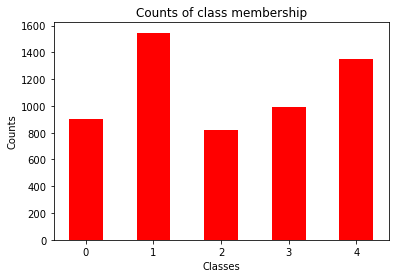

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
width = 0.5       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(uniqs, uniq_counts, width, color='r')

# add some text for labels, title and axes ticks
ax.set_ylabel('Counts')
ax.set_xlabel('Classes')
ax.set_title('Counts of class membership')
ax.set_xticks(uniqs)
plt.show()

In [24]:
df2 = df.drop(df.columns[df.columns.to_series().str.contains('^text_*')], axis = 1)
df2['mdr_text_class'] = km.labels_

In [25]:
df2['days_to_expiry'] = df2['days_to_expiry'].dt.days


In [28]:
df2

,implant_flag,manufacturer_d_name,manufacturer_d_country,device_name,device_class,medical_specialty_description,age_of_device_days,days_to_expiry,mdr_text_class
0,0,0,0,0,3,0,1503 days,1102.0,4
1,0,1,0,1,3,1,1296 days,1461.0,2
2,0,2,0,0,3,0,2096 days,1118.0,3
3,0,3,0,1,3,1,1384 days,614.0,0
4,0,3,0,1,3,1,1690 days,680.0,1
5,0,1,0,1,3,1,560 days,707.0,1
6,0,3,0,0,3,0,2738 days,612.0,1
7,0,3,0,0,3,0,3179 days,702.0,1
8,0,3,0,1,3,1,2329 days,722.0,2
9,0,3,0,1,3,1,2595 days,698.0,2


In [26]:
# X = df2[df2.columns != 'age_of_device_days'].as_matrix

X = df2.ix[:, df2.columns != 'age_of_device_days'].values
days = df2['age_of_device_days']
y = days.dt.days.values

In [27]:
print ([X,  y])

[array([[0, 0, 0, ..., 0, 1102.0, 4],
       [0, 1, 0, ..., 1, 1461.0, 2],
       [0, 2, 0, ..., 0, 1118.0, 3],
       ..., 
       [0, 1, 0, ..., 1, 729.0, 1],
       [0, 1, 0, ..., 1, 721.0, 2],
       [0, 1, 0, ..., 1, 718.0, 2]], dtype=object), array([1503, 1296, 2096, ..., 4438, 1932,  111], dtype=int64)]
